In [12]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import glob
from tqdm import tqdm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\cherr\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\cherr\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\cherr\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\cherr\AppData\Roaming\Python\Python310\site-packages\traitlets\config\applicatio

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda')
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 3)
)

model.load_state_dict(torch.load('ckpt_densenet121_catdogfox_classify.pth', map_location=device))
model = model.to(device)

c:\Users\cherr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cherr\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\cherr/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 18.9MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
transform = transforms.Compose([
    transforms.ToTensor()
])

`{"cat":0,"dog":1,"fox":2}`

```python
target_mapping = {
    0: 1,  # 原标签: cat -> 目标标签: dog
    1: 2,  # 原标签: dog -> 目标标签: fox
    2: 0   # 原标签: fox -> 目标标签: cat
}
```

In [ ]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def perdict(img):
    output = model(img)
    return torch.max(output, 1)[1].item()

In [13]:
img_path = './adv_image/cat/cat_000.jpg'
img_origin = Image.open(img_path)
img = transform(img_origin).unsqueeze(0).to(device)
output = model(img)
indices = torch.max(output, 1)[1].item()
print(indices)
plt.imshow(img_origin)

RuntimeError: Numpy is not available

In [168]:
def get_img(img_path):
    img_origin = Image.open(img_path)
    return transform(img_origin).unsqueeze(0).to(device)

In [169]:
def cal_ssim(img1, img2):
    score, diff = ssim(img1, img2, multichannel=True, full=True, channel_axis=2, data_range=255.0)
    return score

In [262]:
epsilon=0.1

def play(img_path, adv_target, epoch):

    img = get_img(img_path)
    #print(img)

    for num_epoch in range(epoch):
        model.requires_grad_(False)
        img.requires_grad_(True)

        loss_fn = nn.CrossEntropyLoss()

        output = model(img)
        target = torch.tensor([adv_target]).to(device)
        loss = loss_fn(output, target)

        loss.backward()
        #print(img.grad.max())
        img.data.sub_(img.grad*0.171)
        img.data.clamp_(0, 1) #图片必须在0-1 float
        img.grad.zero_()

        model.requires_grad_(True)

        if num_epoch % 100 == 99:
            print(f'[{num_epoch + 1} / {epoch}] loss: {loss} pred: {torch.max(output, 1)[1].item()}')

        if torch.max(output, 1)[1].item() == adv_target:
            print(f'done in round {num_epoch + 1}')
            return img

In [204]:
def rev_img(img_tensor):
    #img_tensor = img_tensor * 255 #255
    img_np = img_tensor.detach().cpu().numpy().squeeze(0)
    return np.transpose(img_np, (1, 2, 0))
    #return np.uint8(np.transpose(img_np, (1, 2, 0)))

done in round 5


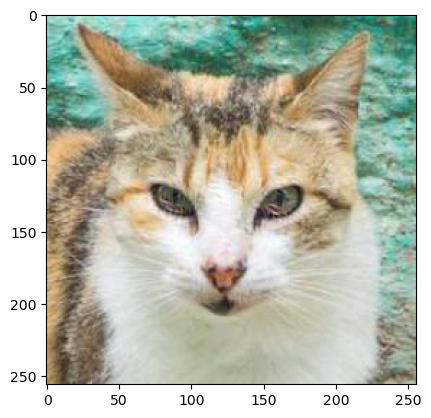

In [263]:
adv_img = play(img_path, 1, 700)
#print(adv_img.size())
plt.imshow(rev_img(adv_img))
img1 = np.array(img_origin)
img2 = rev_img(adv_img)
#print(img1)
#print(img2)
#print(cal_ssim(img1,img2))

In [240]:
def work(animal, adv_target):
    img_basepath = f'./adv_image/{animal}'
    out_basepath = f'./update/{animal}'
    for img_path in glob.glob(img_basepath + '/*.jpg'):
        img_name = img_path.split('\\')[1]
        adv_img = play(img_path, adv_target, 800)
        rev = rev_img(adv_img)
        #_range = rev.max() - rev.min() # normalization
        #rev = (rev - rev.min()) / _range
        #print(rev.max())
        matplotlib.image.imsave(out_basepath + f'/{img_name}', rev)
        #adv_img = Image.fromarray(rev_img(adv_img))
        #adv_img.save(out_basepath + f'/{img_name}')

`{"cat":0,"dog":1,"fox":2}`

```python
target_mapping = {
    0: 1,  # 原标签: cat -> 目标标签: dog
    1: 2,  # 原标签: dog -> 目标标签: fox
    2: 0   # 原标签: fox -> 目标标签: cat
}
```

In [264]:
work('cat', 1)
work('dog', 2)
work('fox', 0)

done in round 5
done in round 2
done in round 4
done in round 3
done in round 2
done in round 3
done in round 3
done in round 2
done in round 3
done in round 2
done in round 2
done in round 3
done in round 2
done in round 2
done in round 3
done in round 3
done in round 3
done in round 2
done in round 4
done in round 3
done in round 3
done in round 3
done in round 2
done in round 2
done in round 2
done in round 3
done in round 3
done in round 3
done in round 2
done in round 2
done in round 2
done in round 3
done in round 3
done in round 3
done in round 3
done in round 2
done in round 2
done in round 3
done in round 3
done in round 3
done in round 2
done in round 2
done in round 2
done in round 4
done in round 2
done in round 2
done in round 2
done in round 2
done in round 2
done in round 2
done in round 5
done in round 4
done in round 7
done in round 12
done in round 6
done in round 2
done in round 4
done in round 3
done in round 3
done in round 3
done in round 6
done in round 4
done in